<a href="https://colab.research.google.com/github/ManojKesani/100-Days-Of-ML-Code/blob/master/STL10_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt



In [ ]:
!nvidia-smi

Mon Feb 22 06:32:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
unsup_data = tfds.as_numpy(tfds.load('stl10', split=['unlabelled'], as_supervised=True, shuffle_files=True,batch_size=-1))

Shuffling and writing examples to /root/tensorflow_datasets/stl10/1.0.0.incompleteKVOEB9/stl10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stl10/1.0.0.incompleteKVOEB9/stl10-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stl10/1.0.0.incompleteKVOEB9/stl10-unlabelled.tfrecord


Dataset stl10 downloaded and prepared to /root/tensorflow_datasets/stl10/1.0.0. Subsequent calls will reuse this data.


In [ ]:
(x_train,y_train_ ),(x_test,y_test_) = tfds.as_numpy(tfds.load('stl10', split=['train','test'], as_supervised=True, shuffle_files=True,batch_size=-1))

In [ ]:
unsup_t = unsup_data[0][0][:80000]
unsup_v = unsup_data[0][0][80000:]

In [ ]:
# from keras.utils import to_categorical
# y_train = to_categorical(y_train_)
# y_test = to_categorical(y_test_)

In [ ]:
from keras.utils import Sequence
import albumentations as A
import cv2


batch_size = 64
class DataGenerator(Sequence):
  def __init__(self, x ,batch_size, transform = None,cutout_transform = None):
    self.data = x
    self.batch_size = batch_size
    self.transform = transform
    self.cutout_transform = cutout_transform
    # self.labels = y

  def __len__(self):
    return int(np.floor(len(self.data) / self.batch_size))

  def __getitem__(self,index):
    # print('working on batch ',index)
    imgs = self.data[index*self.batch_size:(index+1)*self.batch_size]
    # labels = self.labels[index*self.batch_size:(index+1)*self.batch_size]

    x_in = np.empty((batch_size, 96, 96, 3), dtype=np.float32)
    x_out = np.empty((batch_size, 96, 96, 3), dtype=np.float32)
    # y = np.empty((batch_size,10))
    for idx, foo in enumerate(imgs):

      # y[idx] = foo[1]
      
      if self.transform is not None and self.cutout_transform is not None:
        image = foo
        transformed = self.transform(image=image)
        transformed_image = transformed["image"]

        c_transformed = self.cutout_transform(image = transformed_image )
        c_transformed_image = c_transformed['image']

        x_out[idx] = transformed_image/255.
        x_in[idx] = c_transformed_image/255.

      else:
        x[idx] = foo/255.

    return (x_in,x_out)
 

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(),
    A.RandomSizedCrop([80,80],96,96),
    
    # A.Transpose()
])

cutout_transform = A.Compose([A.Cutout(num_holes=8, max_h_size=16, max_w_size=16,p=0.5)])

unsup_train_data = DataGenerator(unsup_t, batch_size,transform=transform,cutout_transform = cutout_transform)
unsup_val_data = DataGenerator(unsup_v, batch_size,transform=transform,cutout_transform = cutout_transform)

sup_train_data = DataGenerator(x_train, batch_size,transform=transform,cutout_transform = cutout_transform)
sup_test_data = DataGenerator(x_test, batch_size,transform=transform,cutout_transform = cutout_transform)

# validation_data = DataGenerator(x_test,y_test, batch_size,transform=transform)

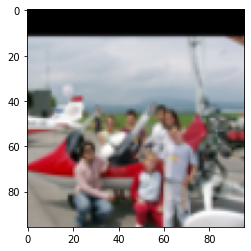

In [ ]:
img,out = next(iter(unsup_train_data))
plt.imshow(img[42])

In [161]:

import keras
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip = None):
    u = keras.layers.UpSampling2D((2, 2))(x)
    if xskip is not None:
      c = keras.layers.Concatenate()([u, xskip])
    return u

def dense(nodes,activation = 'relu'):
  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Dense(nodes,activation=activation)
  )
  return result

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.ReLU())

  return result#

from tensorflow.keras import layers



class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [162]:
def encoder(input_shape = (96,96,3),latent_dim = 2048):
  f = [8, 16, 32, 64, 128,256]
  inputs = keras.layers.Input(input_shape)

  e0 = inputs
  e1 = stem(e0, f[0])
  e2 = residual_block(e1, f[1], strides=2)
  e3 = residual_block(e2, f[2], strides=2)
  e4 = residual_block(e3, f[3], strides=2)
  e5 = residual_block(e4, f[4], strides=2)
  e6 = residual_block(e5, f[5], strides=2)

  x = layers.Flatten()(e6)
  x = layers.Dense(16, activation="relu")(x)
  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])

  encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")

  return encoder



In [163]:
encoder = encoder()
# tf.keras.utils.plot_model(encoder, show_shapes=True, dpi=64)
# encoder.output

In [164]:
def decoder(latent_dim = 2048):
  f = [8, 16, 32, 64, 128,256]
  latent_inputs = keras.Input(shape=(latent_dim,))
  x = layers.Dense(3 * 3 * f[-1], activation="relu")(latent_inputs)
  x = layers.Reshape((3, 3, f[-1]))(x)

  u1 = upsample_concat_block(x)
  d1 = residual_block(u1, f[4])
  u2 = upsample_concat_block(d1)
  d2 = residual_block(u2, f[3])
  u3 = upsample_concat_block(d2)
  d3 = residual_block(u3, f[2])
  u4 = upsample_concat_block(d3)
  d4 = residual_block(u4, f[1])
  u5 = upsample_concat_block(d4)
  d5 = residual_block(u5, f[0])

  outputs = keras.layers.Conv2D(3, (1, 1), padding="same", activation="sigmoid")(d5)
  decoder = keras.Model(inputs = latent_inputs,outputs = outputs,name = 'decoder' )

  return decoder

In [165]:
decoder = decoder()
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)


In [166]:
def vae_model(encoder = encoder,decoder = decoder,input_shape = (96,96,3),latent_dim = 512):
  input = keras.layers.Input(input_shape)
  z_mean, z_log_var, z = encoder(input)
  reconstruction = decoder(z)

  model = keras.Model(inputs = input, outputs = [z_mean, z_log_var, z,reconstruction])

  return model


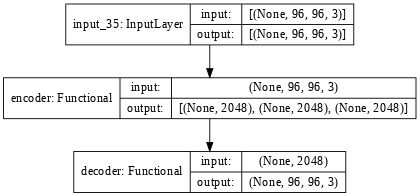

In [167]:
vae_model = vae_model()
tf.keras.utils.plot_model(vae_model, show_shapes=True, dpi=64)


In [168]:
vae_model.output

[<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'encoder')>,
 <KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'encoder')>,
 <KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'encoder')>,
 <KerasTensor: shape=(None, 96, 96, 3) dtype=float32 (created by layer 'decoder')>]

In [175]:
class VAE(keras.Model):
    def __init__(self, model, **kwargs):
        super(VAE, self).__init__(**kwargs)
        # self.encoder = encoder
        # self.decoder = decoder
        self.model = model
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self,input_tensor,training=False):
      return self.model(input_tensor,training = training)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        x_in,x_out = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z, reconstruction = self.model(x_in)
            # reconstruction = self.decoder(z)
            # reconstruction_loss = keras.losses.MSE(data, reconstruction)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(x_out, reconstruction), axis=(1, 2)
                )/96*96*3
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        x_in,x_out = data

        z_mean, z_log_var, z, reconstruction = self.model(x_in)
        # reconstruction_loss = keras.losses.MSE(data, reconstruction)
        reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(x_out, reconstruction), axis=(1, 2)
                )/96*96*3
            )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [176]:
from keras.callbacks import LearningRateScheduler ,ReduceLROnPlateau,TensorBoard,LambdaCallback
from keras import backend as K

stl10_vae = VAE(vae_model)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=5, min_lr=1e-6, verbose=1)
train_lr_callback = LambdaCallback( on_epoch_begin= lambda epoch,logs: print("LearningRate of %e" % (K.eval(stl10_vae.optimizer._decayed_lr('float32').numpy())) ))
lr = 5e-4
opt = keras.optimizers.Adam(lr=lr)
stl10_vae.compile(optimizer=opt)

history = stl10_vae.fit(unsup_train_data,
                                    epochs=200,
                                    callbacks=[reduce_lr,TensorBoard(log_dir='/content/output'),train_lr_callback],
                                    validation_data=unsup_val_data
                      #  , verbose=1
                                    )

Epoch 1/200
LearningRate of 5.000000e-04
1250/1250 [==============================] - 128s 100ms/step - loss: 16865.5653 - reconstruction_loss: 16653.0410 - kl_loss: 117.5377 - val_loss: 16680.8496 - val_reconstruction_loss: 16575.6035 - val_kl_loss: 105.2564
Epoch 2/200
LearningRate of 5.000000e-04
1250/1250 [==============================] - 125s 100ms/step - loss: 16701.8379 - reconstruction_loss: 16584.8535 - kl_loss: 108.4665 - val_loss: 16650.8086 - val_reconstruction_loss: 16542.4609 - val_kl_loss: 108.3428
Epoch 3/200
LearningRate of 5.000000e-04
1250/1250 [==============================] - 126s 100ms/step - loss: 16664.6262 - reconstruction_loss: 16555.1641 - kl_loss: 108.1937 - val_loss: 16637.1738 - val_reconstruction_loss: 16526.1211 - val_kl_loss: 111.0472
Epoch 4/200
LearningRate of 5.000000e-04
1250/1250 [==============================] - 125s 100ms/step - loss: 16662.0722 - reconstruction_loss: 16535.5195 - kl_loss: 108.6226 - val_loss: 16589.5957 - val_reconstruction_l

KeyboardInterrupt: ignored

In [177]:
inp,ou = next(iter(unsup_val_data))
_,_,_,out = stl10_vae.predict(inp)

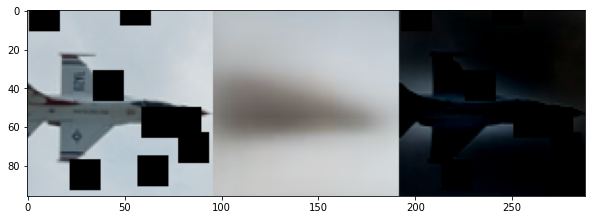

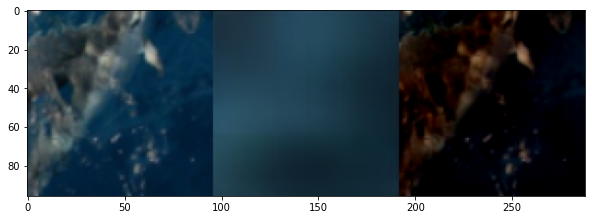

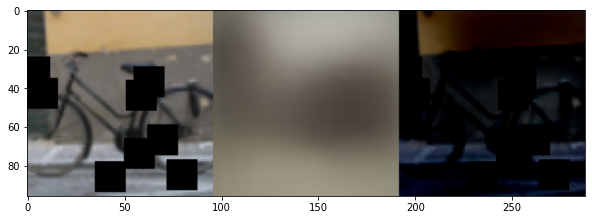

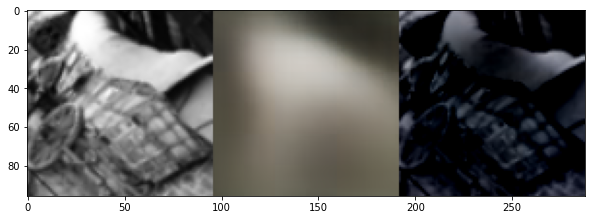

In [178]:
for i in range(out.shape[0]):
  if i>3:
    break
  plt.figure(figsize=(10,10))
  image = np.hstack((inp[i],out[i],inp[i]-out[i]))
  plt.imshow(image)